<a href="https://colab.research.google.com/github/hanjunyeong/CV/blob/main/CV_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Colab에서 OpenCV 이미지 표시용

# 이미지 업로드 창 띄우기
from google.colab import files
uploaded = files.upload()

filename = next(iter(uploaded))

img = cv.imread(filename)


# 파일 이름 지정
img = cv.resize(img, dsize=(0, 0), fx=0.25, fy=0.25)

# 감마 보정 함수 정의
def gamma(f, gamma=1.0):
    f1 = f / 255.0
    return np.uint8(255 * (f1 ** gamma))  # L = 256 가정

# 감마 값별 결과 생성
g1 = gamma(img, 3.0)
g2 = gamma(img, 4.0)
g3 = gamma(img, 5.0)

# 결과 이미지 연결 (수평 스택)
gc = np.hstack((g1, g2, g3))

# BGR을 RGB로 변환 (matplotlib이나 Colab에서 보기 좋게)
gc_rgb = cv.cvtColor(gc, cv.COLOR_BGR2RGB)

# 이미지 출력
plt.figure(figsize=(12, 6))
plt.imshow(gc_rgb)
plt.title("Gamma Correction: 3.0 | 4.0 | 5.0")
plt.axis('off')
plt.show()

'''
Fig. 3.9(a)는 전체적으로 밝기가 고르게 퍼져 있어 명암 대비가 낮은 상태였다.
감마 보정(3.0, 4.0, 5.0)을 순차적으로 적용하면서, 밝은 영역은 더 억제되고
어두운 영역은 강조되어 윤곽이 점점 뚜렷해졌다.
이는 고감마 값이 고역 정보(경계선, 디테일)를 부각시키는 효과가 있다는 것을 보여준다.
추가적으로 히스토그램 평활화와 대비 스트레칭을 실험했을 때,
감마 보정보다는 자연스럽지는 않지만 대비는 더 강하게 조정되었다.
따라서 영상의 밝기 범위와 텍스처 성분에 따라 다양한 변환을 조합하는 것이 중요함을 확인할 수 있었다.
'''

TypeError: 'NoneType' object is not subscriptable

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 이미지 업로드
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 이미지 불러오기
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

if img is None:
    print("이미지 불러오기 실패: 업로드된 파일을 확인하세요.")
    exit()

# Piecewise-Linear 명암 대비 스트레칭 함수 정의
def contrast_stretching(image, r1, s1, r2, s2):
    LUT = np.zeros(256, dtype=np.uint8)
    for r in range(256):
        if r < r1:
            LUT[r] = int((s1 / r1) * r)
        elif r1 <= r <= r2:
            LUT[r] = int(((s2 - s1) / (r2 - r1)) * (r - r1) + s1)
        else:
            LUT[r] = int(((255 - s2) / (255 - r2)) * (r - r2) + s2)
    return LUT[image]

# 명암 대비 스트레칭 파라미터 설정
r1, s1 = 70, 30
r2, s2 = 140, 220
stretched_img = contrast_stretching(img, r1, s1, r2, s2)

# 임계값 기준 이진화
_, thresholded_img = cv2.threshold(stretched_img, 128, 255, cv2.THRESH_BINARY)

# (a) 그래프용 변환 함수 시각화 데이터 생성
r = np.arange(0, 256)
s = np.piecewise(
    r,
    [r < r1, (r >= r1) & (r <= r2), r > r2],
    [lambda r: (s1 / r1) * r,
     lambda r: ((s2 - s1) / (r2 - r1)) * (r - r1) + s1,
     lambda r: ((255 - s2) / (255 - r2)) * (r - r2) + s2]
)

# 이미지 시각화
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(r, s, color='black')
plt.title('(a) Transformation Function')
plt.xlabel('Input Intensity r')
plt.ylabel('Output Intensity s')
plt.grid(True)

plt.plot(r1, s1, 'ro')  # (r1, s1)
plt.text(r1 + 5, s1, f'({r1},{s1})', color='red')

plt.plot(r2, s2, 'bo')  # (r2, s2)
plt.text(r2 + 5, s2, f'({r2},{s2})', color='blue')

plt.subplot(2, 2, 2)
plt.imshow(img, cmap='gray')
plt.title('(b) Original Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(stretched_img, cmap='gray')
plt.title('(c) Contrast-Stretched Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(thresholded_img, cmap='gray')
plt.title('(d) Thresholding Result')
plt.axis('off')

plt.tight_layout()
plt.show()

cv2.imwrite("contrast_stretched.tif", stretched_img)
cv2.imwrite("thresholded.tif", thresholded_img)

'''
원본 영상은 밝기 범위가 좁아 전체적으로 명암 대비가 낮은 low-contrast 영상이다.
Piecewise-linear transformation을 통해 (r1=70, r2=140) 구간을 중심으로
입력 밝기를 재매핑함으로써 전체 대비를 증가시킨다.

이로 인해 (c)처럼 어두운 부분은 더 어둡게, 밝은 부분은 더 밝게 되며
경계가 훨씬 뚜렷해졌다.

이후 이진화 처리에서는 임계값(128)을 기준으로 픽셀을 분리하여
밝은 영역과 어두운 영역을 이분법적으로 나눠 뚜렷한 구조 인식이 가능해진다.
'''

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 이미지 업로드
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 이미지 불러오기 (Grayscale)
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

if img is None:
    print("이미지를 불러올 수 없습니다. 업로드된 파일을 확인하세요.")
    exit()

# 필터 정의
filters = {
    "Mean Filter": np.ones((3, 3), dtype=np.float32) / 9,
    "Gaussian Filter": np.array([
        [0.0030, 0.0133, 0.0219, 0.0133, 0.0030],
        [0.0133, 0.0596, 0.0983, 0.0596, 0.0133],
        [0.0219, 0.0983, 0.1621, 0.0983, 0.0219],
        [0.0133, 0.0596, 0.0983, 0.0596, 0.0133],
        [0.0030, 0.0133, 0.0219, 0.0133, 0.0030]
    ], dtype=np.float32),
    "Sharpening Filter": np.array([
        [0, -1, 0],
        [-1, 4, -1],
        [0, -1, 0]
    ], dtype=np.float32),
    "Edge Detection 1": np.array([
        [-1, 0, 0],
        [ 0, 1, 0],
        [ 0, 0, 1]
    ], dtype=np.float32),
    "Edge Detection 2": np.array([
        [ 0,  1,  0],
        [-1,  0,  1],
        [ 0, -1,  0]
    ], dtype=np.float32),

    "Laplacian 4-connected": np.array([
        [ 0, -1,  0],
        [-1,  4, -1],
        [ 0, -1,  0]
    ], dtype=np.float32),
    "Laplacian 8-connected": np.array([
        [-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1]
    ], dtype=np.float32),
}

# 필터 적용
filtered_images = {name: cv2.filter2D(img, -1, kernel) for name, kernel in filters.items()}

# 시각화
plt.figure(figsize=(16, 8))
plt.subplot(2, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

for i, (name, result_img) in enumerate(filtered_images.items()):
    plt.subplot(2, 4, i+2)  # i+2 = 2~8
    plt.imshow(result_img, cmap='gray')
    plt.title(name)
    plt.axis('off')

plt.tight_layout()
plt.show()

'''
다양한 컨볼루션 필터를 사용하여 하나의 이미지에 대해 여러 처리를 수행해 보았다.
Mean과 가우시안 필터는 전체적으로 노이즈를 줄이는 효과가 있으며,
특히 가우시안은 자연스러운 흐림 효과로 더 부드러운 경계 처리를 가능하게 한다.

반면 Sharpening 필터는 경계선의 선명도를 크게 향상시켜 구조 인식이 쉬워졌으며,
엣지 검출 필터는 특정 방향의 대각선 경계를 뚜렷하게 나타낸다.

Laplacian 필터는 방향성과 무관하게 경계를 검출하는 데 사용되며,
4-connected는 중심에 국한된 연산이지만 8-connected는 더욱 넓은 방향성을 가지므로
더 강하고 세밀한 경계 추출이 가능했다.
'''

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 이미지 업로드
uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

if img is None:
    print("이미지 불러오기 실패")
    exit()

# 45도 방향 Sobel 변형 마스크
sobel_45 = np.array([
    [ 0,  1,  2],
    [-1,  0,  1],
    [-2, -1,  0]
], dtype=np.float32)

# -45도 방향 Sobel 변형 마스크
sobel_neg_45 = np.array([
    [ 2,  1,  0],
    [ 1,  0, -1],
    [ 0, -1, -2]
], dtype=np.float32)

# 컨볼루션 적용
edge_45 = cv2.filter2D(img, -1, sobel_45)
edge_neg_45 = cv2.filter2D(img, -1, sobel_neg_45)

# 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edge_45, cmap='gray')
plt.title('45° Edge (↘)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edge_neg_45, cmap='gray')
plt.title('-45° Edge (↙)')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 파일 업로드
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 이미지 불러오기 (흑백)
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# 구조 요소 설정 (타원형 커널)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# ① Morphological Opening만 적용 (기존 방식)
opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# ② Morphological Smoothing = Opening 후 Closing
opened_then_closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

# 결과 시각화
titles = ['Original', 'Opening Only', 'Opening + Closing (Smoothing)']
images = [img, opened, opened_then_closed]

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 이미지 업로드
uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# 대각선 구조 요소 (↘ 방향)
diag_kernel = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0]
], dtype=np.uint8)

# Morphological Opening 적용
img_opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, diag_kernel)

# 결과 시각화
titles = ['Original', 'Morphological Open (↘ kernel)']
images = [img, img_opened]

plt.figure(figsize=(10, 4))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
'''
영상 내 ↘ 방향의 대각선 선분만 선택적으로 제거하기 위해,
해당 방향에 민감한 구조 요소(kernel)를 사용한 Morphological Opening 연산을 수행하였다.

Opening 연산은 밝은 구조 중 커널과 일치하는 패턴만을 남기기 때문에,
↘ 방향으로 연결되지 않은 작은 밝은 선분은 제거되었으며,
결과적으로 해당 방향의 엣지 성분이 약화되었다.

이는 특정 방향의 구조만 선택적으로 제거하거나 강조할 때 유용한 방식이며,
구조 요소(kernel)의 방향과 크기에 따라 결과가 크게 달라짐을 확인할 수 있었다.

'''


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 이미지 업로드
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 이미지 불러오기 (Grayscale)
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# 1. Sobel (x + y 방향 합성)
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobel_x, sobel_y).astype(np.uint8)

# 2. Laplacian
laplacian = cv2.Laplacian(img, cv2.CV_64F, ksize=3)
laplacian = np.uint8(np.absolute(laplacian))

# 3. Canny
canny = cv2.Canny(img, 100, 200)

# 4. Morphological Gradient
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
morph_gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)

# 시각화
titles = ['Original', 'Sobel', 'Laplacian', 'Canny', 'Morphological Gradient']
images = [img, sobel, laplacian, canny, morph_gradient]

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

'''
Sobel 연산은 영상의 수직·수평 경계를 효과적으로 검출하였으며,
Laplacian은 방향성 없이 전체적인 경계를 강조했지만 노이즈도 함께 부각되었다.

반면, Canny는 노이즈를 효과적으로 억제하면서 가장 정교한 엣지 결과를 보여주었고,
구조가 잘 연결된 선명한 엣지를 확인할 수 있었다.

Morphological Gradient는 이미지의 밝기 경계를 기준으로 형태 기반 엣지를 부드럽게 추출하였고,
영상 내 구조의 윤곽을 간단히 파악할 수 있는 결과를 생성하였다.
'''

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 이미지 업로드
uploaded = files.upload()
filename = list(uploaded.keys())[0]
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# 디스크 구조 요소 생성 함수 (radius = 3)
def disk_kernel(radius):
    size = 2 * radius + 1
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))

# Morphological Smoothing (Opening → Closing) with radius = 3
kernel_r3 = disk_kernel(3)
opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_r3)
morph_smooth = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_r3)

# 일반 Smoothing Filter (Gaussian Blur)
gaussian_smooth = cv2.GaussianBlur(img, (5, 5), 0)

# 시각화
titles = ['Original', 'Morphological Smoothing (r=3)', 'Gaussian Smoothing']
images = [img, morph_smooth, gaussian_smooth]

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

'''
동일한 영상에 대해 두 가지 smoothing 기법을 적용하여 비교하였다.
Morphological Smoothing은 radius 3짜리 디스크 구조 요소를 사용하여
밝은 노이즈와 어두운 틈을 효과적으로 제거하면서도
경계선과 세부 구조를 잘 유지하였다.

반면 Gaussian Blur(Smoothing Filter)는 Noise들이 더 커지는 효과가 들었다.

따라서 노이즈 제거와 동시에 구조 보존이 중요한 경우에는
Morphological Smoothing이 더 적합한 방법이라 판단된다.
'''


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 1. 이미지 업로드
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2. 이미지 읽기 (Grayscale)
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# 3. 이미지 유효성 검사
if img is None:
    raise ValueError("이미지 불러오기 실패! 파일명을 확인하세요.")

# 4. 구조 요소 생성 (radius = 50 → size = 101)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (101, 101))

# 5. 배경 제거 (Top-hat = 원본 - Opening)
background = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
foreground = cv2.subtract(img, background)

# 6. Otsu 이진화
_, binary = cv2.threshold(foreground, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 7. 시각화
titles = ['Original', 'Top-hat (Foreground)', "Otsu's Threshold"]
images = [img, foreground, binary]

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

'''
배경에 밝기 기울기가 존재하는 영상에서 객체(쌀알)를 안정적으로 분리하기 위해
Top-hat 연산을 활용하여 배경을 제거한 후, Otsu 이진화를 적용하였다.

구조 요소는 쌀알보다 충분히 큰 반지름 50짜리 원형 커널을 사용하였으며,
Top-hat 연산을 통해 배경의 영향을 줄이고 foreground만 강조된 영상을 얻을 수 있었다.

이후 Otsu의 자동 임계값 이진화를 수행한 결과, 배경의 밝기 기울기에 영향받지 않고
쌀알만 성공적으로 추출된 결과를 확인할 수 있었다.

이 방식은 밝기 변화가 있는 영상에서의 효과적인 전처리 + 이진화 조합으로 매우 유용하다.
'''


Saving Fig0943(a)(dark_blobs_on_light_background) (1).tif to Fig0943(a)(dark_blobs_on_light_background) (1) (1).tif


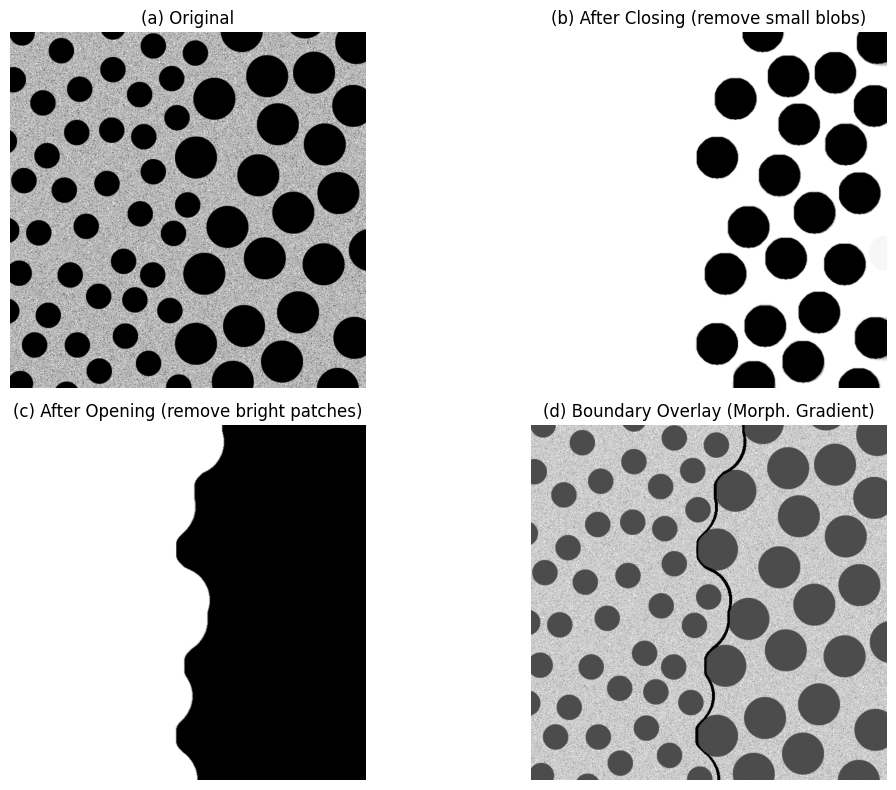

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 1. 이미지 업로드
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2. 이미지 읽기 (Grayscale)
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise ValueError("이미지를 불러올 수 없습니다.")

# 3. (b) 작은 얼룩 제거 - Closing (radius 15 → size 60) 교재에는 30으로 나와있음
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (60, 60))
closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_close)

# 4. (c) 밝은 패치 제거 - Opening (radius 60 → size 110) 교재에는 60으로 나와있음
kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (110, 110))
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)

# 5. (d) 형태학적 경계 추출
kernel_grad = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
gradient = cv2.morphologyEx(opened, cv2.MORPH_GRADIENT, kernel_grad)

# 6. 경계선 원본에 덧씌우기 (검정색)
overlay = img.copy()
overlay[gradient > 0] = 0

# 7. 시각화
titles = [
    '(a) Original',
    '(b) After Closing (remove small blobs)',
    '(c) After Opening (remove bright patches)',
    '(d) Boundary Overlay (Morph. Gradient)'
]
images = [img, closed, opened, overlay]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
